A fine-tuned language model for pictionary word list completion (topic/category phrase + example words -> list of 30 examples). For example, one may complete the list

"A list of round fruits: peach, apricot, lime, plum,"

with

"mango, cherry, pineapple, strawberry, pumpkin, watermelon, orange, pomegranate, melon, apple, pear, grapefruit, papaya, lemon, kiwi, passionfruit, blueberry, raspberry, blackberry, cantaloupe, nectarine, pitaya, persimmon, durian, guava, jackfruit, avocado, lychee, soursop, guarana, mangosteen, blackcurrant, cranberry"

using this model. These words should be compatible with pictionary/skribbl.io; i.e., "sketchable" within a few minutes, and easily recognisable. Scroll to the end for more examples, or see the file `data/examples.txt`. Sketchability parameter estimation examples can also be found in `data/data.tsv`.

In [1]:
import csv
import time
import string
import numpy as np
import pandas as pd
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from transformers import GPT2ForSequenceClassification, GPT2LMHeadModel, ReformerModelWithLMHead, \
                         get_linear_schedule_with_warmup
from pytorch_transformers import GPT2Tokenizer
from Learning import *
dev = "cpu"#"cuda" if pt.cuda.is_available() else "cpu"
d = device = pt.device(dev)

I0123 15:16:02.665653 13448 modeling_bert.py:226] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
I0123 15:16:02.673632 13448 modeling_xlnet.py:339] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alfew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Complete.


In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large", padding=True)

I0123 15:16:32.986577 13448 tokenization_utils.py:384] loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-large-vocab.json from cache at C:\Users\alfew\.cache\torch\pytorch_transformers\69f8d734111f39eaa51a85907bfdc81a7ef42242d638ffab6f77df305402b2b2.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
I0123 15:16:32.987574 13448 tokenization_utils.py:384] loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-large-merges.txt from cache at C:\Users\alfew\.cache\torch\pytorch_transformers\38d28acc17953e356348dca948e152c653c0ccf5058a552eea30168e27f02046.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


In [3]:
cats, cats_sing, phrases = Listset().load()  # Import word lists dataset

In [4]:
tokenizer.encode("A list of round fruits: apples, oranges, pears,"), \
    tokenizer.encode("A list of round fruits: apples,"), \
    tokenizer.encode("oranges, pears,")

([317, 1351, 286, 2835, 15921, 25, 22514, 11, 48389, 11, 279, 4127, 11],
 [317, 1351, 286, 2835, 15921, 25, 22514, 11],
 [48389, 11, 279, 4127, 11])

In [5]:
   ###   Options   ###

model_name = "ernst_one"
test_set_frac = 0.25                 # Fraction of samples to keep as separate test set (word lists)
sample_test_n = 25                   # Number of randomly generated prompts for each sample when testing model
log_period_batches = 25              # Batches per iteration
learning_rate = 1e-5                 # Adam learning rate (default is 5e-5, sentiment classification example had 2e-5)
adam_epsilon = 1e-8                  # Adam epsilon (default is 1e-8)
n_sched_warmup = 0                   # Linear scheduler for optimizer number of warmup steps
batch_size = bsz = 8                 # Samples per batch
N_train_batches = int(1e7 / bsz)     # Total number of batches to show model
min_nw, max_nw = 0.17, 0.8           # Minimum and maximum fraction of list to keep when truncating
max_listlen = 20                     # Maximum number of words in the list when creating a prompt (at least prior to * max_nw)
lidstone_e = 0.0                     # Smoothing for possible words/subwords which are not in the missing list words set
max_len = 96                         # Manually specified in order to match a power of 2 (todo: find opt 64 < x < 96)

In [6]:
lprompts_encoded = [[tokenizer.encode(prompt), "types of" in prompt] for prompt in lprompts]
cats_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats]
cats_sing_e = [[tokenizer.encode(c + ': ') for c in cs] for cs in cats_sing]
phrases_e = [[tokenizer.encode(p + ', ') for p in ps] for ps in phrases]
N_tokens = len(tokenizer)
N_wordlists = len(cats)

In [7]:
lprompts_encoded = [[pt.tensor(prmt, device=d), pt.tensor(typesof, device=d)] for (prmt, typesof) in lprompts_encoded]
cats_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_e]
cats_sing_e = [[pt.tensor(c, device=d) for c in cs] for cs in cats_sing_e]
phrases_e = [[pt.tensor(p, device=d) for p in ps] for ps in phrases_e]
N_tokens = pt.tensor(N_tokens, device=d)
max_len = pt.tensor(max_len, device=d)
bsz = pt.tensor(batch_size, device=d)
y_zero = (lidstone_e / N_tokens).repeat(N_tokens)

In [8]:
# Generate a fixed test set and save to disk, using nw_draw = 15. This function defines the next list token prediction problem
def gen_truncated_list(prmt, p):  # prmt = prompt tokens, p = list phrases tokens list
    tkzs, sent, tkix = [], [], 0
#     incl_words = pt.randperm(len(p))[:min(max_listlen, len(p))]
    incl_words = np.random.choice(len(p), min(max_listlen, len(p)), replace=False)
    for phz_i in incl_words:
        phz_enc = p[phz_i]
        tkzs.append((tkix, phz_enc))
        tkix += len(phz_enc)
        sent.append(phz_enc)
    sent = pt.hstack(sent)
    missing_w = [p[i] for i in range(len(p)) if i not in incl_words]
    trunc_ix = np.random.randint(round(tkix * min_nw), round(tkix * max_nw))
    trunc_n = min([(trunc_ix - ix) for (ix, enc) in tkzs if ix <= trunc_ix])  # N. end phrase tokens
    missing_w += [enc for (ix, enc) in tkzs if ix >= (trunc_ix - trunc_n)]
    missing_matches = missing_w
    if trunc_n > 0:
        phr_start = trunc_ix - trunc_n
        partial_phr = sent[phr_start:trunc_ix]
        missing_matches = [enc for enc in missing_w if len(enc) >= trunc_n and all(enc[:trunc_n] == partial_phr)]
    next_tokens = [enc[trunc_n] for enc in missing_matches]
    norm = len(next_tokens) * (1.0 + lidstone_e)
    tunit, y_ = pt.tensor(1 / norm, device=d), y_zero.clone()
    for token in next_tokens: y_[token] += tunit
    return pt.hstack([prmt, sent[:trunc_ix]]), y_
def gen_samples_uniform(xcp, xcs, xp, nw, verbose=False):  # Weight testing samples (word lists) uniformly
    xs, ys, sqlens, j = [], [], [], 0
    for i in range(len(xcp)):
        x, y, sqlen = [], [], []
        cp, cs, p = xcp[i], xcs[i], xp[i]
        for m in range(nw):
            prmt, typesof = lprompts_encoded[np.random.randint(len(lprompts_encoded))]
            cat_ix = np.random.randint(len(cp))
            x_, y_ = gen_truncated_list(pt.hstack([prmt, cp[cat_ix] if typesof else cs[cat_ix]]), p)
            x.append(x_)
            y.append(y_)
            sqlen.append(len(x_))
            j += 1
            if verbose and j % 100 == 0:
                sys_print("\rDone: " + str(j))
        xs.append(x)
        ys.append(y)
        sqlens.append(sqlen)
    if verbose: sys_print("\rDone: " + str(j) + ", finished!\n")
    return xs, ys, sqlens
def gen_samples(xcp, xcs, xp, n):  # Maximise training batch diversity by randomly sampling the word lists
    xs, ys, sqlens, j = [], [], [], 0
    n_sets = len(xcp)
    for m in range(n):
        i = np.random.randint(n_sets)
        cp, cs, p = xcp[i], xcs[i], xp[i]
        prmt, typesof = lprompts_encoded[np.random.randint(len(lprompts_encoded))]
        cat_ix = np.random.randint(len(cp))
        x_, y_ = gen_truncated_list(pt.hstack([prmt, cp[cat_ix] if typesof else cs[cat_ix]]), p)
        xs.append(x_)
        ys.append(y_)
        sqlens.append(len(x_))
    return xs, ys, sqlens

In [9]:
N_test = int(test_set_frac * N_wordlists)
N_train = N_wordlists - N_test
# test_idx = np.random.choice(N_wordlists, N_test, replace=False)
test_idx = np.array([3, 7])
cats_e_test, cats_sing_e_test = [cats_e[i] for i in test_idx], [cats_sing_e[i] for i in test_idx]
phrases_e_test = [phrases_e[i] for i in test_idx]
train_idx = [i for i in range(N_wordlists) if i not in test_idx]
cats_e_train, cats_sing_e_train = [cats_e[i] for i in train_idx], [cats_sing_e[i] for i in train_idx]
phrases_e_train = [phrases_e[i] for i in train_idx]
test_cats = [cats[i][0] for i in test_idx]
test_xs, test_ys, test_sqlens = gen_samples_uniform(cats_e_test, cats_sing_e_test, phrases_e_test, sample_test_n, verbose=True)

Done: 50, finished!


In [10]:
save_ld((test_xs, test_ys, test_sqlens), "test.data")

In [11]:
# test_xs, test_ys, test_sqlens = load_ld("test.data")

In [12]:
# Define next batch function
def adapt_form(xs, ys, sqlens):
    xs = pt.vstack([F.pad(x, (0, max_len - len(x)), mode='constant', value=pad_token) for x in xs])
    return xs, pt.vstack(ys), pt.tensor(sqlens, device=d)
def next_batch(sz):
    global cats_e_train, cats_sing_e_train, phrases_e_train
    return adapt_form(*gen_samples(cats_e_train, cats_sing_e_train, phrases_e_train, sz))

In [14]:
print(gc.collect())
create_folder("models")
create_folder("models/pretrained")
create_folder("models/pretrained/GPT2LMHead")
# model_ = GPT2ForSequenceClassification.from_pretrained('gpt2-large',
model_ = GPT2LMHeadModel.from_pretrained('gpt2-large',
    output_hidden_states=True, output_attentions=True, 
    cache_dir="models/pretrained/GPT2LMHead")
# model_.parallelize()
model_ = model_.to(d)
print("GPT2 device:", model_.device)
model_.resize_token_embeddings(N_tokens)
pad_token = model_.config.pad_token_id = model_.config.eos_token_id
pad_token = pt.tensor(pad_token, device=d)
n_embd = pt.tensor(model_.config.n_embd, device=d)
# model = nn.parallel.DistributedDataParallel(
model = nn.DataParallel(
    model_, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else model_
print("Pretrained parameters loaded")
gc.collect()

Pretrained parameters loaded


979

In [19]:
llayer = nn.Linear(n_embd, N_tokens, bias=False).to(d)#.cpu()
nn.init.xavier_uniform_(llayer.weight)
llayer = nn.DataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))) if dev != "cpu" else llayer
# llayer = nn.parallel.DistributedDataParallel(llayer, device_ids=list(range(pt.cuda.device_count()))).to(d)
# softmax = nn.Softmax()
bcewl_loss = nn.BCEWithLogitsLoss().to(d)#.cpu()
bcewl_loss = nn.DataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d) if dev != "cpu" else bcewl_loss
# bcewl_loss = nn.parallel.DistributedDataParallel(bcewl_loss, device_ids=list(range(pt.cuda.device_count()))).to(d)
# nll_loss = nn.NLLLoss()
# kl_loss = nn.KLDivLoss()
optimizer = pt.optim.AdamW(model.parameters(), lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=n_sched_warmup, num_training_steps=N_train_batches)
def sequence_mask(lengths, maxlen=None, dtype=pt.int):
    if maxlen is None:
        maxlen = lengths.max()
    row_vector = pt.arange(0, maxlen, 1, device=d)
    matrix = pt.unsqueeze(lengths, dim=-1)
    mask = row_vector < matrix

    mask = mask.type(dtype)
    return mask
def train_step():
    global model, llayer, bcewl_loss, optimizer, scheduler, bsz
    x_batch, y_batch, sqlens_batch = next_batch(bsz)
    
    model.zero_grad()
    mask = sequence_mask(sqlens_batch, max_len)
    outputs = model(x_batch.long(), attention_mask=mask)
    out_idx = pt.unsqueeze(pt.unsqueeze(sqlens_batch - 1, 1).repeat((1, n_embd)), 1).type(pt.int64)
    outs = pt.gather(outputs[2][-1].to(d), 1, out_idx).squeeze(1)
#     outs = pt.gather(outputs[2][-1].cpu(), 1, out_idx).squeeze(1)
    logits = llayer(outs)
    
#     logsofts = pt.log(softmax(logits))
    loss = bcewl_loss(logits, y_batch.float())#.to(d)#.cpu()
    loss = loss.mean()
    correct = pt.mean((y_batch[pt.arange(batch_size), pt.argmax(logits, axis=1)] > (lidstone_e / N_tokens)).float())
    loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()
    return loss_, correct_

def inference(x, sqlens):
    global model, llayer

    x, sqlens = x.to(d), sqlens.to(d)#.cpu()
    mask = sequence_mask(sqlens, max_len)
    outputs = model(x.long(), attention_mask=mask)
    out_idx = pt.unsqueeze(pt.unsqueeze(sqlens - 1, 1).repeat((1, n_embd)), 1).type(pt.int64)
    outs = pt.gather(outputs[2][-1], 1, out_idx).squeeze(1)
#     outs = pt.gather(outputs[2][-1].cpu(), 1, out_idx).squeeze(1)
    logits = llayer(outs)
    return logits
def eval_test(x, y, sqlens):
    global bcewl_loss

    with pt.no_grad():
        logits = inference(x, sqlens)
        loss = bcewl_loss(logits, y.float())#.to(d)#.cpu()
        loss = loss.mean()
        correct = pt.mean((y[pt.arange(x.shape[0]), pt.argmax(logits, axis=1)] > (lidstone_e / N_tokens)).float())
        loss_, correct_ = loss.detach().cpu().numpy(), correct.detach().cpu().numpy()
    return loss_, correct_

# top_next = [self.tokenizer.decode(i.item()).strip() for i in probs.topk(k)[1]]

In [20]:
batch_i = 0
best_acc, best_loss = 0, np.inf
best_acc_idx = -1
create_folder("models")
create_folder("model_logs")
create_folder("models/" + model_name)
graphs_folder = "graphs"
create_folder(graphs_folder)
train_loss, train_accuracy, test_loss, test_accuracy = [], [], [], []

In [21]:
def iterate_training(verbose=True):
    global model, batch_i, best_acc, best_loss, best_acc_idx, train_loss, train_accuracy, test_loss, test_accuracy
    
    model.train()
    iter_loss, iter_accuracy, b_no_inp = [], [], 0
    while batch_i < N_train_batches:
        batch_i += 1
        gc.collect()
        if dev != "cpu": pt.cuda.empty_cache()
        b_loss, b_accuracy = train_step()
        if verbose:
            sys_print('\rLoss, accuracy: ' + str(np.mean(b_loss)) + ', ' + str(np.mean(b_accuracy)) + \
                      ' @ batch '+ str(batch_i) + ' (' + str(batch_i * batch_size) + ' samples) complete.                  ')
        iter_loss.append(b_loss)
        iter_accuracy.append(b_accuracy)
        
        if (batch_i - 1) % log_period_batches == 0:  # Test on test set
            model.eval()
            loss, accuracy = [], []
            for i in range(N_test):
                test_X, test_Y, test_Sqlens = adapt_form(test_xs[i], test_ys[i], test_sqlens[i])
                feed_batches = [range(len(test_X))[i * bsz:(i + 1) * bsz] for i in range((len(test_X) // bsz) + 1)]
                if dev != "cpu": pt.cuda.empty_cache()
                ls, cs = zip(*[eval_test(test_X[inds], test_Y[inds], test_Sqlens[inds]) for inds in feed_batches])
                loss.append(np.mean(ls))
                accuracy.append(np.mean(cs))
                print('\n' + test_cats[i] + ': ' + str(loss[-1]) + ', ' + str(accuracy[-1]))
            
            test_l, test_a = np.mean(loss), np.mean(accuracy)
            test_loss.append(test_l)
            test_accuracy.append(test_a)
            train_l, train_a = np.mean(iter_loss), np.mean(iter_accuracy)
            train_loss.append(train_l)
            train_accuracy.append(train_a)
            iter_loss, iter_accuracy = [], []
            
            val_a = 0
            if test_a > best_acc:      # Save best accuracy model
                best_acc = test_a
                best_loss = test_l
                best_acc_idx = batch_i // log_period_batches
                pt.save({"model": model.state_dict(),
                         "llayer": llayer.state_dict(),
#                          "softrmax": softrmax.state_dict(),
                         "bcewl_loss": bcewl_loss.state_dict(),
#                          "nll_loss": nll_loss.state_dict(),
#                          "kl_loss": kl_loss.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "scheduler": scheduler.state_dict(),
                         }, "./models/" + model_name + '/' + model_name)
                b_no_inp = 0
            else:
                b_no_inp += log_period_batches
                
            if verbose:
                clear_output()
                print("Batch", batch_i, ':', train_a, test_a, "loss:", train_l, test_l, \
                      "Best:", best_acc, best_loss, 'idx:', best_acc_idx)
                fig = plt.figure()
                fig.set_size_inches(16, 5)
                g = fig.add_subplot(1,2,1)
                g.grid()
                g.plot(train_accuracy, label='train acc')
                g.plot(test_accuracy, label='test acc')
                g.legend(loc='lower right')
#                 g.axhline(y=0.714, ls='--', color='grey')

                g = fig.add_subplot(1,2,2)
                g.grid()
                g.plot(train_loss, label='train loss')
                g.plot(test_loss, label='test loss')
                g.legend(loc='upper right')

                save_ld((train_accuracy, test_accuracy, train_loss, test_loss),
                        "model_logs/" + model_name + '_log_latest', pad=False)
                plt.savefig(graphs_folder + '/' + model_name + "_curve_latest" + '.pdf', format='pdf')
                plt.show()
            model.train()
    return best_acc, best_loss

Batch 1 : 0.0 0.0 loss: 0.6986929 0.69654155 Best: 0 inf idx: -1


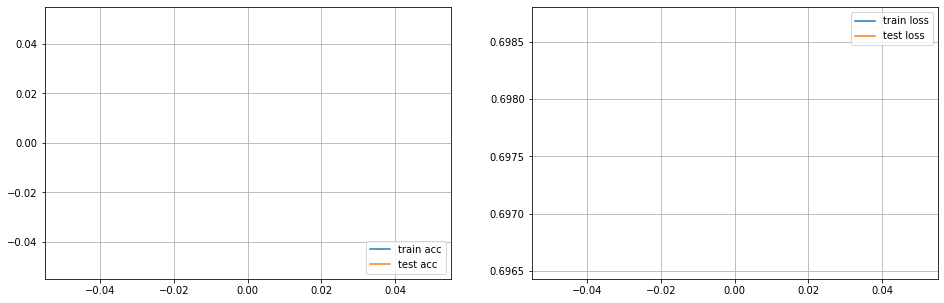

Loss, accuracy: 0.69701207, 0.0 @ batch 2 (16 samples) complete.                  

In [ ]:
print(gc.collect())
iterate_training()

In [ ]:
# Uncomment to load a model
# gc.collect()
# checkpoint = pt.load("./models/" + model_name + '/' + model_name)
# model.load_state_dict(checkpoint['model'])
# llayer.load_state_dict(checkpoint['llayer'])
# bcewl_loss.load_state_dict(checkpoint['bcewl_loss'])
# optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])

In [ ]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < pt.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = pt.sort(logits, descending=True)
        cumulative_probs = pt.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

In [ ]:
def append_next_token(sent, top_k=-1, top_p=0.9, temperature=1.0):
    global model
    model.eval()
    tokens = tokenizer.encode(sent)
    x = pt.tensor([tokens], device=d)
    if dev != "cpu": pt.cuda.empty_cache()
    logits = inference(x, pt.tensor([len(tokens)]), device=d)[0]
    logits /= temperature
    logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
    probs = F.softmax(logits, dim=0)
    token = pt.multinomial(probs, 1).numpy()[0]
    tokens += [token]
    sent = tokenizer.decode(tokens)
    print(sent)
    return sent

# Interactive generation

In [ ]:
input_sentence = "A list of types of drink: coffee, water, tea, coke, lemonade, milkshake,"

In [ ]:
input_sentence = append_next_token(input_sentence, top_k=-1, top_p=0.9, temperature=1.0)

Working (reproducible) examples using various non-fine-tuned models (proof of concept):

In [ ]:
# GPT3 (via AI Dungeon) (Randomness = 2.0, model = Dragon):
sentence = "A list of ML algorithms: inverse reinforcement learning, ELMo, decision tree, LDA, "
expected_completion = "MLP, MLL, MMM. You can't believe you're actually using these things!"

sentence = "A list of animals seen in the wild: wolffish, woodlouse, sheep, zebra, yak, "
expected_completion = "goat, fox, dog, rat. You're guessing that a lot of other animals have been seen as well; maybe even all the animals on your list except for wolf and rat?"

In [ ]:
# GPT2 (via Write with Transformer) (Top-p = 0.67, temperature = 1.89, max time = 1.9):
sentence = "A list of round fruits: peach, apricot, lime, plum, blackberry, cantaloupe, nectarine, pitaya, persimmon, "
expected_completion = "mango, papaya and raspberry, as also many"

sentence = "A list of chemical elements: hydrogen, carbon, oxygen, nitrogen, gold, "
expected_completion = "silver, aluminum, potassium and phosphorus; atomic number."

sentence = "A list of microbes found on earth: bacteria, virus, prokaryote, amoeba, "
expected_completion = "archaea, algae, nematode, euk"